### Постановка задачи<a class="anchor" id="course_project_task"></a>
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных<a class="anchor" id="course_project_review"></a>
**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [96]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb


In [97]:
# Магическая команда Jupyter Notebook, используется для того
# чтобы график строился не в отдельном окне, а в ноутбуке с кодом
%matplotlib inline

# настройкая конфигурации ноутбука со значением 'svg' для более четкого отображения графиков
set_matplotlib_formats('svg')

In [98]:
color_custom_pal_good_bad = mpl.colors.LinearSegmentedColormap.from_list('custom-colors', ['green', 'tomato'])
color_custom_pal_good_bad

In [99]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [100]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [101]:
df_train.shape

(7500, 17)

In [102]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

5 колонок заполнены с пропусками: "Annual Income", "Years in current job", "Months since last delinquent", "Bankruptcies", "Credit Score".   Причем физический смысл колонки "Credit Score" не разъяснен в описании.

In [103]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [104]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [105]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [106]:
df_test.shape

(2500, 16)

In [107]:
df_test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Кака и в трайне, 5 колонк заполнены с пропусками: "Annual Income", "Years in current job", "Months since last delinquent", "Bankruptcies ", "Credit Score".

### Общие данные по датасетам

In [108]:
def Weight_Distribution_Of_The_Result_By_Values(df, value_name, result_name):
    """
    # Задача функции - получить процент распределения значений конкретного показателя по целевым значениям.
    Например в датасете есть показатель "Пол", а целевой показатель "Цвет бороды". Функция должна выдать 
    примерно такую картину на датасете из 35 строк.
    
    +---------------+----------+---------+------------------+
    |  Цвет бороды  |  Мужчина | Девушка | Общее количество |
    +---------------+----------+---------+------------------+
    |  Черная       |    1     |    0    |        10        |
    |  Рыжая        |    1     |    0    |         5        |
    |  Русая        |   0,95   |   0,05  |        20        |
    +---------------+----------+---------+------------------+
    
    # Parameters:
    1) df - исходный датасет.
    2) value_name - название показателя (столбца) в котором будут находится значения показателя.
    3) result_name - название показателя (столбца) в котором находятся целевые значения.

    # Returns
    
    Возвращается DataFrame вида, как показано в описании задачи

    """
    
    df_tmp = df.loc[:,[value_name, result_name]]
    df_tmp.insert(2, 'Percent', 1)
    df_tmp = df_tmp.groupby([value_name, result_name]).sum()
    df_tmp = df_tmp.unstack(level = result_name)
    df_tmp.insert(2, 'Quantity', 0)
    df_tmp = df_tmp.fillna(0) # Могут появиться, т.к. вполне вернятно, что каких-то вариантов значений вообще не будет.
    df_tmp['Quantity'] = df_tmp['Percent', 0] + df_tmp['Percent', 1]
    df_tmp['Percent', 0] = df_tmp['Percent', 0] / df_tmp['Quantity']
    df_tmp['Percent', 1] = df_tmp['Percent', 1] / df_tmp['Quantity']

    return df_tmp

In [109]:
df_total = df_train.loc[:,['Credit Default']]
df_total.insert(0, 'Total', 'Total')
df_total = Weight_Distribution_Of_The_Result_By_Values(df_total, 'Total', 'Credit Default')
df_total

Percent           Quantity
Credit Default         0         1         
Total                                      
Total           0.718267  0.281733     7500

Опишем все признаки, которые есть в датасетах на данный момент. Чтобы в дальнейшем было проще выделить новые и используемые в моделировании.

In [110]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Т.е. в общем, по всем данным тренировочного датасета около 72% успешных погашений и около 28% просрочек.

#### Показатель 'Home Ownership'

В обоих датасетах заполнен без пропусков.

In [111]:
df_ho = pd.concat([df_train['Home Ownership'].value_counts(), df_test['Home Ownership'].value_counts()], axis=1).reset_index()
df_ho.columns = ['value', 'train', 'test']
df_ho.append(['', df_train['Home Ownership'].value_counts().dtype, df_test['Home Ownership'].value_counts().dtype],['value', 'train', 'test'])
df_ho

,value,train,test
0,Home Mortgage,3637,1225
1,Rent,3204,1020
2,Own Home,647,248
3,Have Mortgage,12,7


Для лучшего понимания и анализа приведу перевод

* Own Home           - Собственный Дом.
* Home Mortgage      - Ипотека На Жилье.
* Rent               - Аренда.
* Have Mortgage      - Есть Ипотека - смысл этого термина в данной задаче не ясен.

In [112]:
df_test['Home Ownership'].value_counts().dtype

dtype('int64')

Значения в столбце 'Home Owhership' совпадают по набору (да и по распределению) значений. Но поскольку в данный момент мне не очень понятен смысл значения Have Mortgage, мне трудно сделать однозначный выбор - заменить его на наиболее испольуземое Home Mortgage или оставить в виде такой очень не презентабильной выборки. Которая скорее спутает карты и будет способствовать переобучению, чем поможет выделить тенденцию в распределении данных.

Создам dummy-переменные вместо 'Home Ownership' и посмотрю какая будет взаимосвязь с 

Проверим распределение целевых значений по значениям 'Home Ownership'

In [113]:
df_ho = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Home Ownership', 'Credit Default')
df_ho

Percent           Quantity
Credit Default         0         1         
Home Ownership                             
Have Mortgage   0.833333  0.166667       12
Home Mortgage   0.748144  0.251856     3637
Own Home        0.703246  0.296754      647
Rent            0.686954  0.313046     3204

Чтобы убрать явно статистически незначимые значения, заменю Have Mortgage на Rent. Это приблизит распределение удачных выплат по ердитам дя всех значений.

In [114]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', ['Home Ownership']] = 'Rent'
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', ['Home Ownership']] = 'Rent'

#### Показатель 'Tax Liens'
{налоговые обременения}
 
Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.   

In [115]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [116]:
df_test['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

Мне кажется, что это показатель того, сколько налогов должен будет заплатить владелец (жилья и кредита) за свое жилье.

In [117]:
df_tl = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Tax Liens', 'Credit Default')
df_tl

Percent           Quantity
Credit Default         0         1         
Tax Liens                                  
0.0             0.719658  0.280342   7366.0
1.0             0.710843  0.289157     83.0
2.0             0.500000  0.500000     30.0
3.0             0.500000  0.500000     10.0
4.0             0.500000  0.500000      6.0
5.0             0.500000  0.500000      2.0
6.0             1.000000  0.000000      2.0
7.0             1.000000  0.000000      1.0

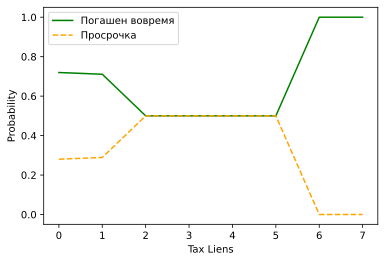

In [118]:
x = df_tl.index.to_numpy()
y1 = df_tl['Percent', 0].to_numpy()
y2 = df_tl['Percent', 1].to_numpy()

plt.plot(x, y1, label='Погашен вовремя', color='green')
plt.plot(x, y2, label='Просрочка', color='orange', linestyle='dashed')

plt.xlabel("Tax Liens")
plt.ylabel("Probability")

plt.legend()

plt.show()

Наблюдается интересная картина. Налоговое обременение от 2-х до 5-ти процентов делит пополам вероятность погашения кредита. До 2-х процентов вероятность погасить вовремя равна 71%, а выше 6-ти вероятность погашения стопроцентная.

Сверну этот признак до 4-х значений

In [119]:
df_train.loc[(df_train['Tax Liens'] > 1) & (df_train['Tax Liens'] < 6), ['Tax Liens']] = 2
df_test.loc[(df_test['Tax Liens'] > 1) & (df_test['Tax Liens'] < 6), ['Tax Liens']] = 2

df_train.loc[df_train['Tax Liens'] > 5, ['Tax Liens']] = 3
df_test.loc[df_test['Tax Liens'] > 5, ['Tax Liens']] = 3

#### Показатель 'Number of Open Accounts'
{Количество открытых счетов}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

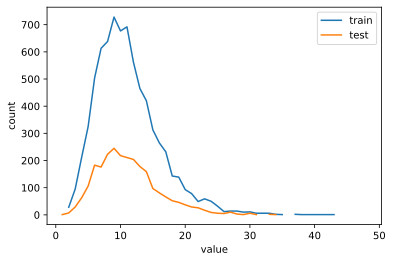

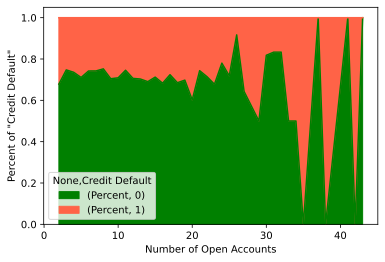

In [120]:
df_noa = pd.concat([df_train['Number of Open Accounts'].value_counts(), df_test['Number of Open Accounts'].value_counts()], axis=1).reset_index()
df_noa.columns = ['value', 'train', 'test']
df_noa.plot(x='value', y=['train','test'], kind='line', ylabel = 'count')

df_noa_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Number of Open Accounts', 'Credit Default')
df_noa_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad)

plt.show()

Из графика видно, что основные значения как тестовой так и тренировочной выборки сосредоточены между 2 и 25.
Для этих значений показателя 'Number of Open Accounts', процент погашенных вовремя кредитов составляет около 70%.

#### Показатель 'Years of Credit History'
{количество лет кредитной истории}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

<AxesSubplot:xlabel='Years of Credit History', ylabel='Percent of "Credit Default"'>

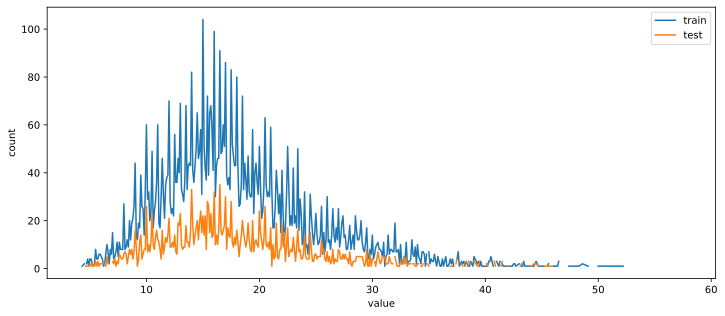

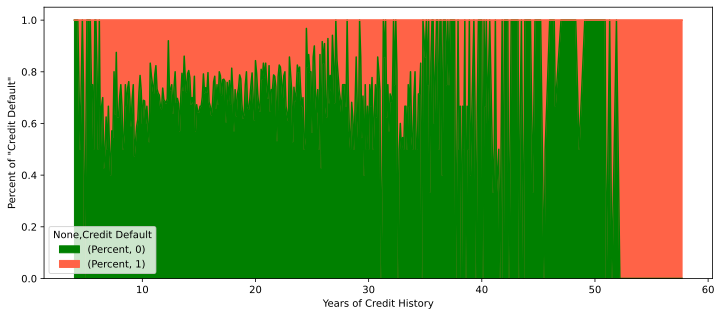

In [121]:
df_ych = pd.concat([df_train['Years of Credit History'].value_counts(), df_test['Years of Credit History'].value_counts()], axis=1).reset_index()
df_ych.columns = ['value', 'train', 'test']
df_ych.plot(x='value', y=['train','test'], kind='line', ylabel = 'count', figsize=(12, 5))

df_ych_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Years of Credit History', 'Credit Default')
df_ych_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))


Из графика видно, что основные значения как тестовой так и тренировочной выборки сосредоточены между 7 и 30.
Для этих значений показателя 'Years of Credit History', процент погашенных вовремя кредитов составляет около 67%.

#### Показатель 'Maximum Open Credit'
{наибольший открытый кредит}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

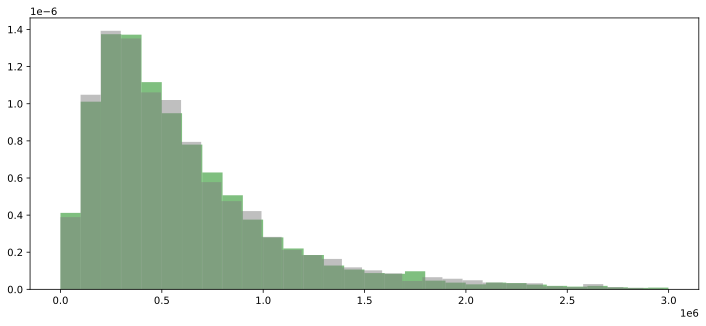

In [122]:
plt.figure(figsize=(12, 5))
train_moc_lim = df_train.loc[df_train['Maximum Open Credit']  < 3000000, ['Maximum Open Credit']]
test_moc_lim = df_test.loc[df_test['Maximum Open Credit']  < 3000000, ['Maximum Open Credit']]

plt.hist(train_moc_lim['Maximum Open Credit'], bins=30, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_moc_lim['Maximum Open Credit'], bins=30, density=True, alpha=0.5, label='test', color='grey')

plt.show()

Распределение показателя совпрадает в тренировочном и в тестовом датасетах.

<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Percent of "Credit Default"'>

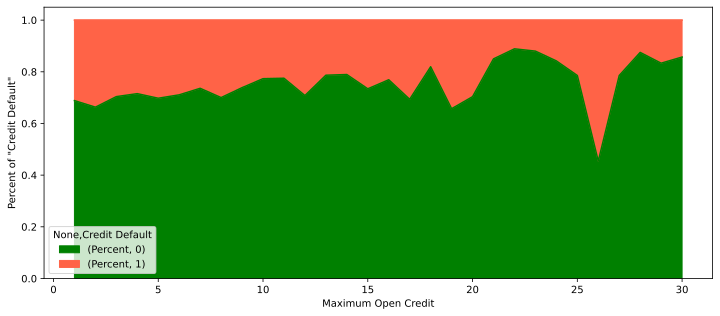

In [123]:
df_moc = df_train.loc[df_train['Maximum Open Credit']  < 3000000,['Maximum Open Credit', 'Credit Default']]
df_moc['Maximum Open Credit'] = df_moc['Maximum Open Credit'] // 100000 + 1

df_moc_tv = Weight_Distribution_Of_The_Result_By_Values(df_moc, 'Maximum Open Credit', 'Credit Default')
df_moc_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

Среди значимых показателей пошгашенных кредитов около 70 %.

#### Показатель 'Number of Credit Problems'
{количество проблем с кредитом}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

<AxesSubplot:xlabel='Number of Credit Problems', ylabel='Percent of "Credit Default"'>

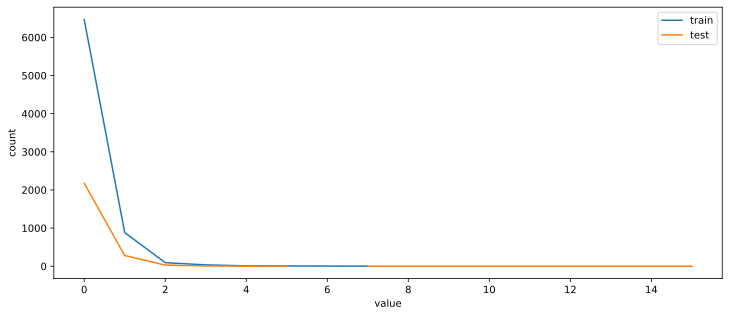

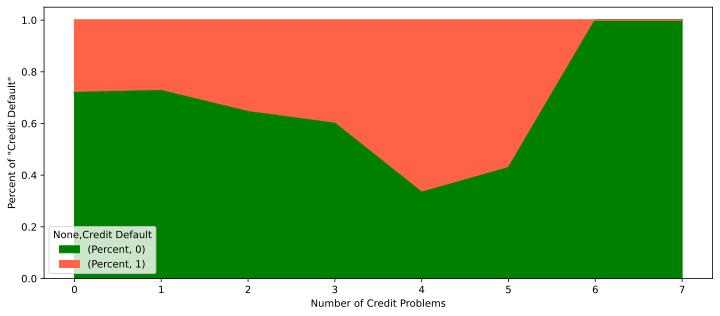

In [124]:
df_ncp = pd.concat([df_train['Number of Credit Problems'].value_counts(), df_test['Number of Credit Problems'].value_counts()], axis=1).reset_index()
df_ncp.columns = ['value', 'train', 'test']
df_ncp.plot(x='value', y=['train','test'], kind='line', ylabel = 'count', figsize=(12, 5))

df_ncp_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Number of Credit Problems', 'Credit Default')
df_ncp_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))


В тренировочной и в тестовых выборках основну массу занимают записи с нулевым количеством проблемных кредитов. при этом процент "успешнных" возвратов находиится на уровне 72.

#### Показатель 'Purpose'
{цель кредита}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

c:\program files\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
c:\program files\python38\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Purpose', ylabel='Percent of "Credit Default"'>

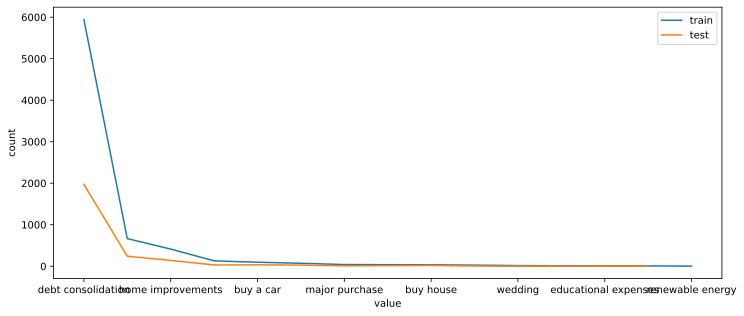

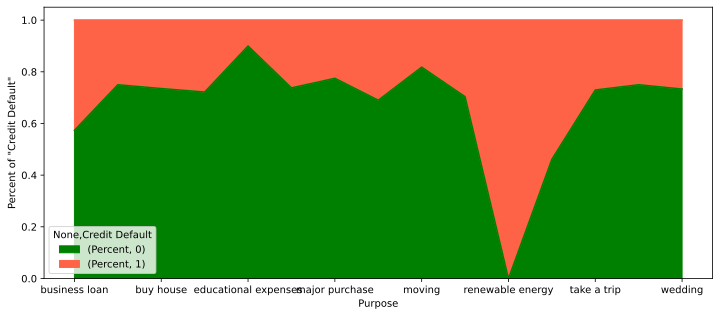

In [125]:
df_p = pd.concat([df_train['Purpose'].value_counts(), df_test['Purpose'].value_counts()], axis=1).reset_index()
df_p.columns = ['value', 'train', 'test']
df_p.plot(x='value', y=['train','test'], kind='line', ylabel = 'count', figsize=(12, 5))

df_p_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Purpose', 'Credit Default')
df_p_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))


Из графиков точной информации не видно, но понятно, что значение "debt consolidation" является основным и в тренировочном датасете и в тестовом.

In [126]:
df_p

,value,train,test
0,debt consolidation,5944,1973.0
1,other,665,240.0
2,home improvements,412,140.0
3,business loan,129,30.0
4,buy a car,96,34.0
5,medical bills,71,27.0
6,major purchase,40,9.0
7,take a trip,37,14.0
8,buy house,34,19.0
9,small business,26,5.0


In [127]:
df_p_tv

Percent           Quantity
Credit Default               0         1         
Purpose                                          
business loan         0.573643  0.426357    129.0
buy a car             0.750000  0.250000     96.0
buy house             0.735294  0.264706     34.0
debt consolidation    0.721736  0.278264   5944.0
educational expenses  0.900000  0.100000     10.0
home improvements     0.737864  0.262136    412.0
major purchase        0.775000  0.225000     40.0
medical bills         0.690141  0.309859     71.0
moving                0.818182  0.181818     11.0
other                 0.703759  0.296241    665.0
renewable energy      0.000000  1.000000      2.0
small business        0.461538  0.538462     26.0
take a trip           0.729730  0.270270     37.0
vacation              0.750000  0.250000      8.0
wedding               0.733333  0.266667     15.0

Для значимых по количеству значений "debt consolidation", "other" и "home improvements" процент возвращенных кредитов - около 71.

#### Показатель 'Term'
{срок кредита}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

In [128]:
df_t = pd.concat([df_train['Term'].value_counts(), df_test['Term'].value_counts()], axis=1).reset_index()
df_t.columns = ['value', 'train', 'test']

df_t_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Term', 'Credit Default')


In [129]:
df_t

,value,train,test
0,Short Term,5556,1861
1,Long Term,1944,639


In [130]:
df_t_tv

Percent           Quantity
Credit Default         0         1         
Term                                       
Long Term       0.580247  0.419753     1944
Short Term      0.766559  0.233441     5556

Один из интересных показателей в данной задаче. Заполнен полностью и отражает одну из зависимостей, на которую можно будет опереться при дальнейшем анализе. Процент вовремя погашенных коротких кредитов 76,6%, долгих - 58%. И коротких кредитов примерно в 2 раза больше, чем длинных. Возможно этот показатель поможет выделить основную тенденцию в распределении общего датасета.

#### Показатель 'Current Loan Amount'
{текущая сумма кредита}

Следующий показатель полностью (без пропусков) заполнненый в обоих датасетах.

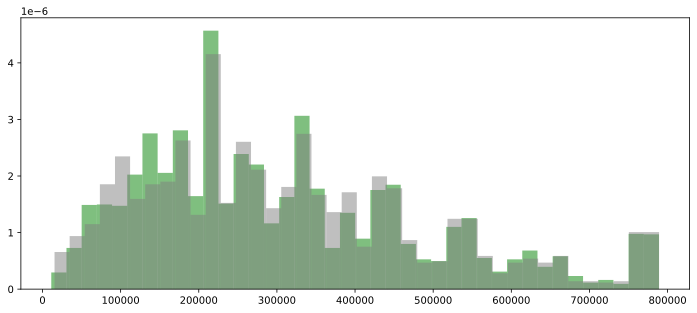

In [131]:
plt.figure(figsize=(12, 5))
train_cla_lim = df_train.loc[df_train['Current Loan Amount']  < 1000000, ['Current Loan Amount']]
test_cla_lim = df_test.loc[df_test['Current Loan Amount']  < 1000000, ['Current Loan Amount']]

plt.hist(train_cla_lim['Current Loan Amount'], bins=40, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_cla_lim['Current Loan Amount'], bins=40, density=True, alpha=0.5, label='test', color='grey')

plt.show()

Распределение показателя совпрадает в тренировочном и в тестовом датасетах. Но значения больше 750 000 можно считать выбросами.

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Percent of "Credit Default"'>

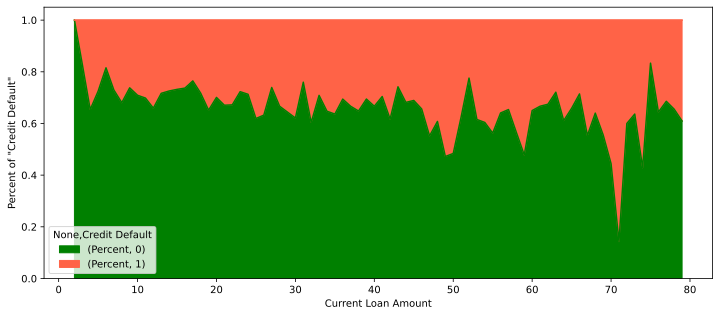

In [132]:
df_cla = df_train[['Current Loan Amount', 'Credit Default']]
df_cla = df_train.loc[df_train['Current Loan Amount']  < 1000000,['Current Loan Amount', 'Credit Default']]
df_cla['Current Loan Amount'] = df_cla['Current Loan Amount'] // 10000 + 1

df_cla_tv = Weight_Distribution_Of_The_Result_By_Values(df_cla, 'Current Loan Amount', 'Credit Default')
df_cla_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

Как и в большинстве предыдущих примеров, средний процент возвратов по значимым значениям 'Current Loan Amount' около 70%.

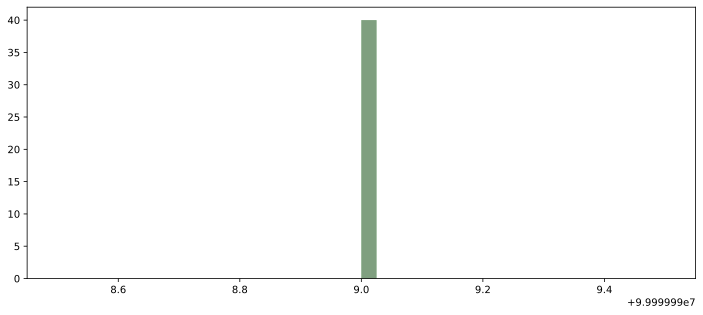

In [133]:
plt.figure(figsize=(12, 5))
train_cla_lim_1 = df_train.loc[df_train['Current Loan Amount']  >= 1000000, ['Current Loan Amount']]
test_cla_lim_1 = df_test.loc[df_test['Current Loan Amount']  >= 1000000, ['Current Loan Amount']]

plt.hist(train_cla_lim_1['Current Loan Amount'], bins=40, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_cla_lim_1['Current Loan Amount'], bins=40, density=True, alpha=0.5, label='test', color='grey')

plt.show()

Есть очень большие значения. 99 999 999. Это явно выбросы. Нужно заменить их на медианные.

In [134]:
cla_median_value = df_train['Current Loan Amount'].median(skipna = True)

df_train.loc[df_train['Current Loan Amount'] > 90000000 , ['Current Loan Amount']] = cla_median_value
df_test.loc[df_test['Current Loan Amount'] > 90000000 , ['Current Loan Amount']] = cla_median_value


#### Показатель 'Current Credit Balance'
{текущий кредитный баланс}

Этотпоказатель полностью (без пропусков) заполнненый в обоих датасетах.

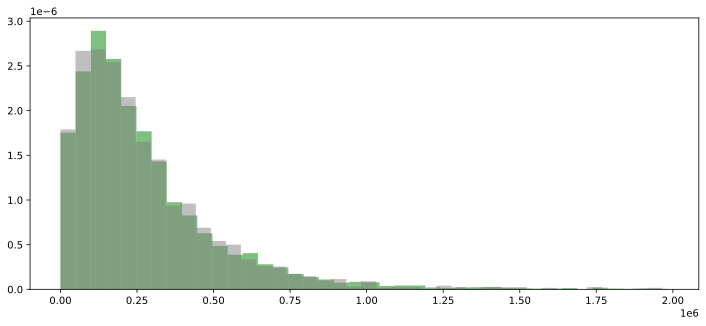

In [135]:
plt.figure(figsize=(12, 5))
train_ccb_lim = df_train.loc[df_train['Current Credit Balance']  < 2000000, ['Current Credit Balance']]
test_ccb_lim = df_test.loc[df_test['Current Credit Balance']  < 2000000, ['Current Credit Balance']]

plt.hist(train_ccb_lim['Current Credit Balance'], bins=40, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_ccb_lim['Current Credit Balance'], bins=40, density=True, alpha=0.5, label='test', color='grey')

plt.show()

Распределение показателя совпрадает в тренировочном и в тестовом датасетах. Существенные данные находятся в интервае от 0 до 1 000 000.

<AxesSubplot:xlabel='Current Credit Balance', ylabel='Percent of "Credit Default"'>

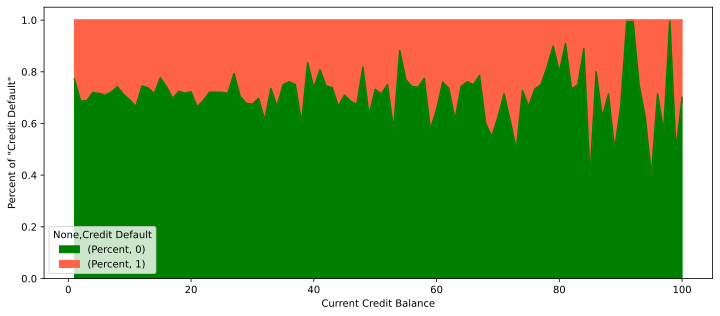

In [136]:
df_ccb = df_train[['Current Credit Balance', 'Credit Default']]
df_ccb = df_train.loc[df_train['Current Credit Balance']  < 1000000,['Current Credit Balance', 'Credit Default']]
df_ccb['Current Credit Balance'] = df_ccb['Current Credit Balance'] // 10000 + 1

df_ccb_tv = Weight_Distribution_Of_The_Result_By_Values(df_ccb, 'Current Credit Balance', 'Credit Default')
df_ccb_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

Как и в большинстве предыдущих примеров, средний процент возвратов по значимым значениям 'Current Credit Balance' около 70%.

#### Показатель 'Annual Income'
{годовой доход}

Этотпоказатель заполнен не полностью. С пропусками в обоих датасетах.

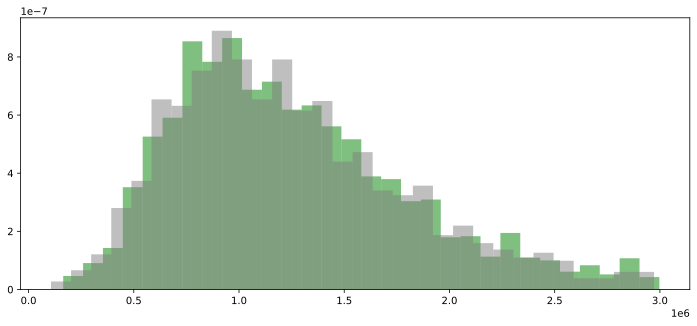

In [137]:
plt.figure(figsize=(12, 5))
train_ai_lim = df_train.loc[df_train['Annual Income']  < 3000000, ['Annual Income']]
test_ai_lim = df_test.loc[df_test['Annual Income']  < 3000000, ['Annual Income']]

plt.hist(train_ai_lim['Annual Income'], bins=30, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_ai_lim['Annual Income'], bins=30, density=True, alpha=0.5, label='test', color='grey')

plt.show()

# df_ai_tv = Weight_Distribution_Of_The_Result_By_Values(train_ai_lim, 'Annual Income', 'Credit Default')
# df_ai_tv


Распределение не нулевых значений примерно совпадает в тренировочном и тестовом датасетах.

<AxesSubplot:xlabel='Annual Income', ylabel='Percent of "Credit Default"'>

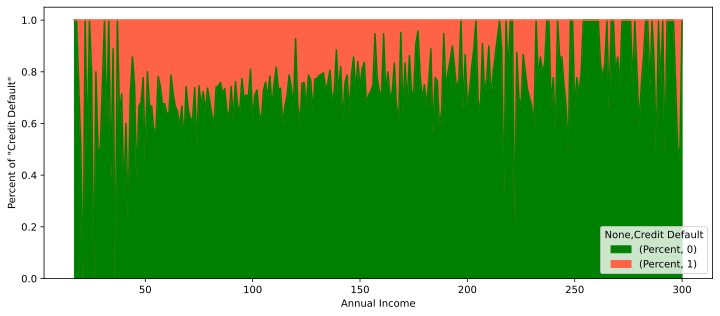

In [138]:
df_ai = df_train[['Annual Income', 'Credit Default']]
df_ai = df_train.loc[df_train['Annual Income']  < 3000000,['Annual Income', 'Credit Default']]
df_ai['Annual Income'] = df_ai['Annual Income'] // 10000 + 1

df_ai_tv = Weight_Distribution_Of_The_Result_By_Values(df_ai, 'Annual Income', 'Credit Default')
df_ai_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

In [139]:
train_ai_n_lim = df_train.loc[df_train['Annual Income'].isnull(), ['Annual Income', 'Credit Default']]

train_ai_n_lim['Annual Income'] = 0
train_ai_n_lim.value_counts()

Annual Income  Credit Default
0              0                 1028
               1                  529
dtype: int64

In [140]:
1028/(1028+529)

0.6602440590879898

Распределение значения NULL по результатам возврата кредита совпадает с распределением успешных возвратов в по другим значениям Annual Income. Поэтому логично будет заменить значения NULL медианой в тренировочном и тестовом датасетах.

Но логично будет добавить еще один признак "Доход известен". Там, где не null и не выброс установим 1. В противном случае - 0.

In [141]:
df_train['Unknown income'] = 0
df_test['Unknown income'] = 0

df_train.loc[df_train['Annual Income'].isnull(), ['Unknown income']] = 1
df_test.loc[df_test['Annual Income'].isnull(), ['Unknown income']] = 1

In [142]:
ai_median_value = df_train['Annual Income'].median(skipna = True)
ai_median_value

1168386.0

In [143]:
df_train.loc[df_train['Annual Income'].isnull(), ['Annual Income']] = ai_median_value
df_test.loc[df_test['Annual Income'].isnull(), ['Annual Income']] = ai_median_value

#### Показатель 'Years in current job'
{количество лет на текущем месте работы}

Очередной показатель заполненый не полностью. С пропусками в обоих датасетах.

In [144]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [145]:
df_train.loc[df_train['Years in current job'].isnull(), ['Years in current job']] = 'Unknown'
df_ycj_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Years in current job', 'Credit Default')
df_ycj_tv

Percent           Quantity
Credit Default               0         1         
Years in current job                             
1 year                0.718254  0.281746      504
10+ years             0.723842  0.276158     2332
2 years               0.726241  0.273759      705
3 years               0.725806  0.274194      620
4 years               0.720682  0.279318      469
5 years               0.718992  0.281008      516
6 years               0.708920  0.291080      426
7 years               0.719697  0.280303      396
8 years               0.728614  0.271386      339
9 years               0.749035  0.250965      259
< 1 year              0.717584  0.282416      563
Unknown               0.630728  0.369272      371

Распределение возвратов и невозвратов среди всех изначально заполненных показателей около 72% в пользу возвратов. А вот не заполненные показатели сильно "портят" эту картину. Скорее всего это говорит о том, что это не очень аккуратное заполнение данных. Причем в категории 9 years, которая тоже выбивается, но в другуюсторону. Мне кажется, что логичнее будет объединить с категорией 9 years. И уменьшить возможность переобучения у системы.

In [146]:
df_train.loc[df_train['Years in current job'] == 'Unknown', ['Years in current job']] = '9 years'
df_ycj_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Years in current job', 'Credit Default')
df_ycj_tv

Percent           Quantity
Credit Default               0         1         
Years in current job                             
1 year                0.718254  0.281746      504
10+ years             0.723842  0.276158     2332
2 years               0.726241  0.273759      705
3 years               0.725806  0.274194      620
4 years               0.720682  0.279318      469
5 years               0.718992  0.281008      516
6 years               0.708920  0.291080      426
7 years               0.719697  0.280303      396
8 years               0.728614  0.271386      339
9 years               0.679365  0.320635      630
< 1 year              0.717584  0.282416      563

In [147]:
df_test.loc[df_test['Years in current job'].isnull(), ['Years in current job']] = '9 years'

#### Показатель 'Months since last delinquent'
{количество месяцев с последней просрочки платежа}

Очередной показатель заполненый не полностью. С пропусками в обоих датасетах.

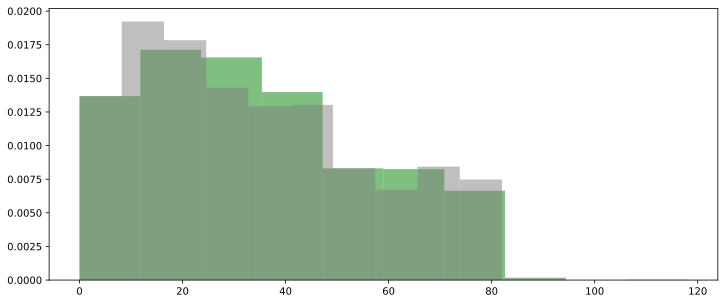

In [148]:
plt.figure(figsize=(12, 5))
plt.hist(df_train['Months since last delinquent'], bins=10, density=True, alpha=0.5, label='train', color='green')
plt.hist(df_test['Months since last delinquent'], bins=10, density=True, alpha=0.5, label='test', color='grey')
plt.show()

<ipython-input-149-41ca8f01b6f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msld['Months since last delinquent'] = df_msld['Months since last delinquent'] // 10 + 1


<AxesSubplot:xlabel='Months since last delinquent', ylabel='Percent of "Credit Default"'>

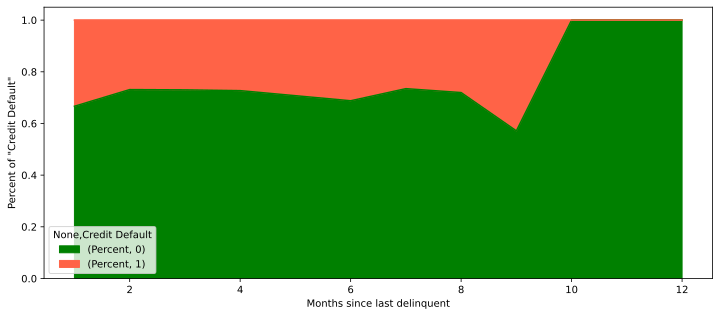

In [149]:
df_msld = df_train[['Months since last delinquent', 'Credit Default']]
df_msld['Months since last delinquent'] = df_msld['Months since last delinquent'] // 10 + 1

df_msld_tv = Weight_Distribution_Of_The_Result_By_Values(df_msld, 'Months since last delinquent', 'Credit Default')
df_msld_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

Значение Null скорее всего связано с тем, что у клиента не было вообще проблем с обслуживанием кредита. Поэтому логично будет добавить еще один показатель, который будет означать - "были просрочки". По умолчанию поставим 1. А там, где значение 'Months since last delinquent' isnull() установим 0.

In [150]:
df_train.insert(10, 'Has delinquent', 1)
df_test.insert(10, 'Has delinquent', 1)

df_train.loc[df_train['Months since last delinquent'].isnull(), ['Has delinquent']] = 0
df_test.loc[df_test['Months since last delinquent'].isnull(), ['Has delinquent']] = 0

Попробуем заменить значения больше 90 (т.е. выбросы, по моему мнению) на 90, а null на 130. И посмотрим что получится. 

In [151]:
df_train.loc[df_train['Months since last delinquent'] > 90 , ['Months since last delinquent']] = 90
df_test.loc[df_test['Months since last delinquent'] > 90 , ['Months since last delinquent']] = 90

df_train.loc[df_train['Months since last delinquent'].isnull(), ['Months since last delinquent']] = 90
df_test.loc[df_test['Months since last delinquent'].isnull(), ['Months since last delinquent']] = 90

<ipython-input-152-41ca8f01b6f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msld['Months since last delinquent'] = df_msld['Months since last delinquent'] // 10 + 1


<AxesSubplot:xlabel='Months since last delinquent', ylabel='Percent of "Credit Default"'>

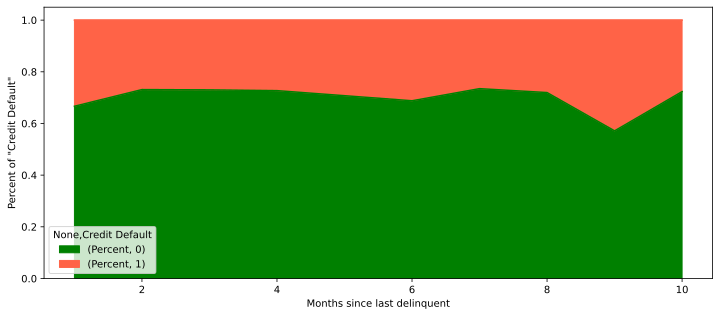

In [152]:
df_msld = df_train[['Months since last delinquent', 'Credit Default']]
df_msld['Months since last delinquent'] = df_msld['Months since last delinquent'] // 10 + 1

df_msld_tv = Weight_Distribution_Of_The_Result_By_Values(df_msld, 'Months since last delinquent', 'Credit Default')
df_msld_tv.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

Распределение возвратов и не возвратов получается более-менее равномерное. Поэтому будем считать, что с нулевыми значениями в этом показателе поборолись.

#### Показатель 'Bankruptcies'
{банкротства}

Очередной показатель заполненый не полностью. С пропусками в обоих датасетах.

In [153]:
df_train.loc[df_train['Bankruptcies'].isnull(), ['Bankruptcies']] = 5
df_test.loc[df_test['Bankruptcies'].isnull(), ['Bankruptcies']] = 5
df_b_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Bankruptcies', 'Credit Default')
df_b_tv

Percent           Quantity
Credit Default         0         1         
Bankruptcies                               
0.0             0.718018  0.281982     6660
1.0             0.723919  0.276081      786
2.0             0.645161  0.354839       31
3.0             0.714286  0.285714        7
4.0             0.500000  0.500000        2
5.0             0.714286  0.285714       14

Распределение результатов в пустых значениях очень похоже на распределение в результата в значении 3. Но выборка настолько мала, что это вполне может быть совпадением. Вообще, мне кажется, что если "запихнуть" все значения больше 1 в 1, ситуация только стабилизируется.

In [154]:
df_train.loc[df_train['Bankruptcies'] > 1, ['Bankruptcies']] = 1
df_test.loc[df_test['Bankruptcies'] > 1, ['Bankruptcies']] = 1
df_b_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Bankruptcies', 'Credit Default')
df_b_tv

Percent           Quantity
Credit Default         0         1         
Bankruptcies                               
0.0             0.718018  0.281982     6660
1.0             0.720238  0.279762      840

#### Показатель 'Credit Score'
{Кто бы знал, что имеется в виду под этим показателем. Скорее всего какой-то рейтинг.}

Очередной показатель заполненый не полностью. С пропусками в обоих датасетах.

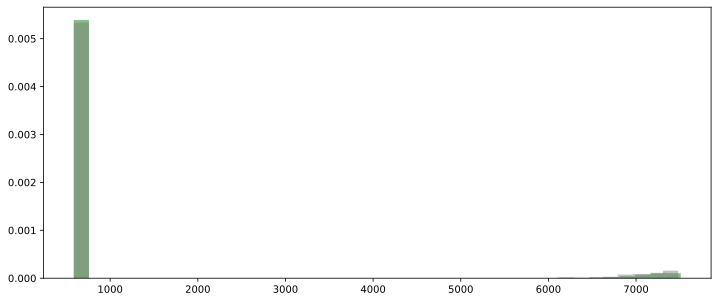

In [155]:
plt.figure(figsize=(12, 5))
plt.hist(df_train['Credit Score'], bins=40, density=True, alpha=0.5, label='train', color='green')
plt.hist(df_test['Credit Score'], bins=40, density=True, alpha=0.5, label='test', color='grey')
plt.show()

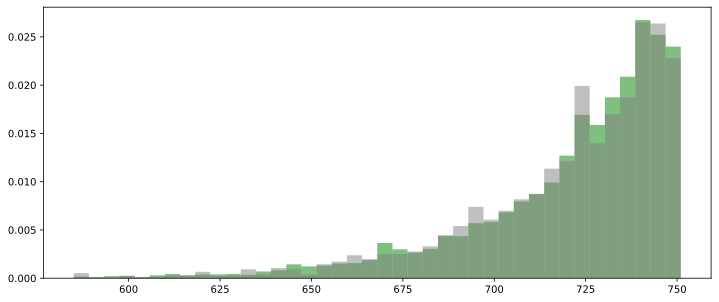

In [156]:
train_cs_lim = df_train.loc[df_train['Credit Score']  < 1000, ['Credit Score']]
test_cs_lim = df_test.loc[df_test['Credit Score']  < 1000, ['Credit Score']]

plt.figure(figsize=(12, 5))
plt.hist(train_cs_lim['Credit Score'], bins=40, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_cs_lim['Credit Score'], bins=40, density=True, alpha=0.5, label='test', color='grey')
plt.show()

C:\Users\maxim\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


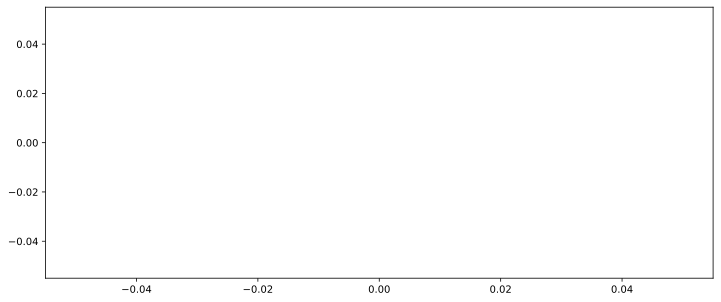

In [157]:
train_cs_lim_1 = df_train.loc[(df_train['Credit Score']  > 1000) & (df_train['Credit Score']  < 6000), ['Credit Score']]
test_cs_lim_1 = df_test.loc[(df_test['Credit Score']  > 1000) & (df_test['Credit Score']  < 6000), ['Credit Score']]

plt.figure(figsize=(12, 5))
plt.hist(train_cs_lim_1['Credit Score'], bins=2, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_cs_lim_1['Credit Score'], bins=2, density=True, alpha=0.5, label='test', color='grey')
plt.show()

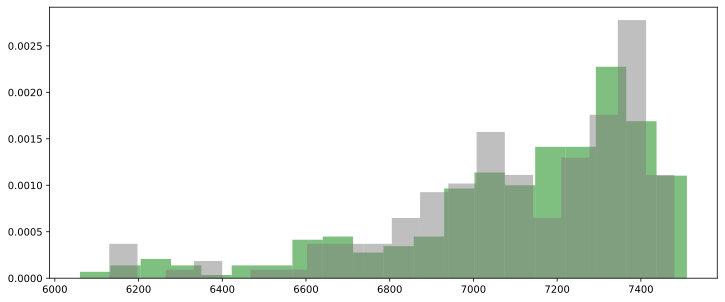

In [158]:
train_cs_lim = df_train.loc[df_train['Credit Score']  > 6000, ['Credit Score']]
test_cs_lim = df_test.loc[df_test['Credit Score']  > 6000, ['Credit Score']]

plt.figure(figsize=(12, 5))
plt.hist(train_cs_lim['Credit Score'], bins=20, density=True, alpha=0.5, label='train', color='green')
plt.hist(test_cs_lim['Credit Score'], bins=20, density=True, alpha=0.5, label='test', color='grey')
plt.show()

In [159]:
df_b_tv = Weight_Distribution_Of_The_Result_By_Values(df_train, 'Credit Score', 'Credit Default')
df_b_tv

Percent      Quantity
Credit Default       0    1         
Credit Score                        
585.0              0.0  1.0      1.0
586.0              0.0  1.0      1.0
588.0              0.0  1.0      1.0
589.0              0.0  1.0      1.0
590.0              1.0  0.0      1.0
...                ...  ...      ...
7470.0             0.0  1.0      4.0
7480.0             0.0  1.0      6.0
7490.0             0.0  1.0      2.0
7500.0             0.0  1.0      2.0
7510.0             0.0  1.0      2.0

[268 rows x 3 columns]

In [160]:
with pd.option_context('display.max_rows', None, 'display.max_columns', df_b_tv.shape[1]):
    print(df_b_tv)

                 Percent           Quantity
Credit Default         0         1         
Credit Score                               
585.0           0.000000  1.000000      1.0
586.0           0.000000  1.000000      1.0
588.0           0.000000  1.000000      1.0
589.0           0.000000  1.000000      1.0
590.0           1.000000  0.000000      1.0
591.0           0.000000  1.000000      1.0
593.0           0.000000  1.000000      1.0
594.0           0.666667  0.333333      3.0
597.0           1.000000  0.000000      2.0
598.0           1.000000  0.000000      1.0
599.0           0.000000  1.000000      1.0
601.0           0.666667  0.333333      3.0
602.0           1.000000  0.000000      1.0
604.0           0.000000  1.000000      1.0
606.0           1.000000  0.000000      1.0
607.0           0.000000  1.000000      1.0
608.0           0.500000  0.500000      4.0
609.0           1.000000  0.000000      1.0
610.0           1.000000  0.000000      1.0
611.0           0.333333  0.6666

Очень интересно.
* Значения меняются в диапозоне от 600 до 750. и от "600\*10" до "750\*10"
* У всех значений от 6000 до 7510 значение целевой переменной - просрочка.
* У значений от 600 до 750 целевая переменная приемущественно "погашен вовремя"
очень жаль, что не заполнены 513 значений в тестовом датасете. :-(
 
Скорее всего это Скоринговый рейтинг. Что косвенно подтверждается вот такими картинками из интернета

<img src="Credit_Score_scale_1200.webp">

И очень похоже, что тем у кого есть просрочка и определен скорринговый рейтинг, просто умножили его рейтинг на 10. Т.е. получается, что в значениях > 6000 зашифрованы неудачно определенные скорренговые рейтинги. Но эта версия не подтвердилась.

In [161]:
train_cs_null = df_train.loc[df_train['Credit Score'].isnull(), ['Credit Score', 'Credit Default']]
train_cs_null['Credit Score'] = 10000

In [162]:
df_cs_tv = Weight_Distribution_Of_The_Result_By_Values(train_cs_null, 'Credit Score', 'Credit Default')
df_cs_tv

Percent           Quantity
Credit Default         0         1         
Credit Score                               
10000           0.660244  0.339756     1557

In [163]:
df_test_cs = df_test.loc[df_test['Credit Score'] < 1000, ['Credit Score']]
df_test_cs.describe()

,Credit Score
count,1827.000000
mean,720.325670
std,27.402793
min,585.000000
25%,708.000000
50%,728.000000
75%,741.000000
max,751.000000


Пришел к выводу, что нужно сдеать свой показатель, который будет отражать логику, заложенную (по моему мнению) в показателе 'Credit Score'. Смысл такой:
* Выявить зависимость. Скорее всего она будет линейная между просрочками и значением 'Credit Score' в промежутке между 580 и 760
* Все значения 'Credit Score' в обоих датасетах выше 6000 сделать нулевыми в новом показателе. Т.к. по факту - есть просрочка
* Все не заполненные значения 'Credit Score' заменить на одно из значений от 585 до 750, где процентное распределение успешных возвратов и просрочек - совпадает с распредлением на общем количестве пустых значений.

<AxesSubplot:xlabel='Credit Score', ylabel='Percent of "Credit Default"'>

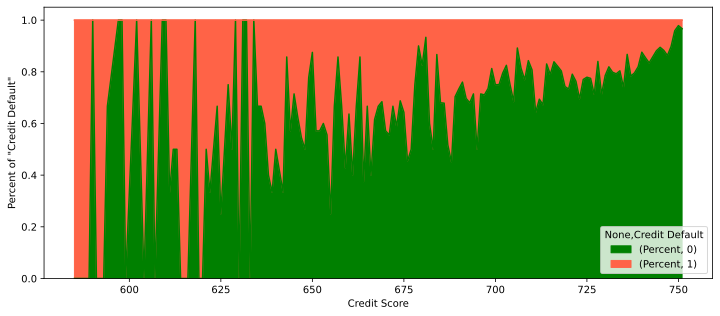

In [164]:
df_b_tv_1 = df_b_tv.loc[(df_b_tv.index > 584) & (df_b_tv.index < 752)]
df_b_tv_1.plot(y=[('Percent', 0),('Percent', 1)], kind='area', ylabel = 'Percent of "Credit Default"', colormap = color_custom_pal_good_bad, figsize=(12, 5))

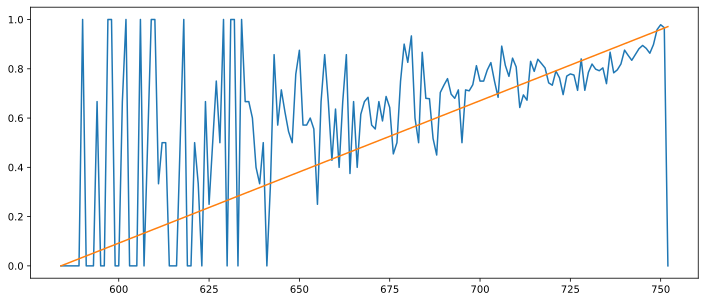

In [165]:
X = np.linspace(584, 752, 169)
Y1 = np.linspace(0, 0, 169)
for ind in X:
    try:
        Y1[int(ind)-584] = df_b_tv.loc[int(ind)][('Percent', 0)]
    except:
        None

Y2 = (X-584)/173

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1, aspect=1)

ax.plot(X, Y1)
ax.plot(X, Y2)

plt.axis('auto')

plt.show()

Считаю, что такое линейное приближение будет достаточно "правдоподобным"

### Построение новых признаков

Создаю новый показатель 'Credit Score C'(т.е. 'Credit Score Custom'):

In [166]:
df_train.insert(16, 'Credit Score C', 0)
df_test.insert(16, 'Credit Score C', 0)

In [167]:
dict_for_csc = dict(zip(X, Y2))

df_train['Credit Score C'] = df_train['Credit Score'].map(dict_for_csc)
df_test['Credit Score C'] = df_test['Credit Score'].map(dict_for_csc)

# В линейном графике процент удачных возвратов при скоринговом рейтинге 699 - 0.6647398843930635 наиболее близко
# совпадает с распределением успешных возвратов для пустого значения скоринга - 0.660244.
# На это значение и можно было бы зменименить null в Credit Score
df_train.loc[df_train['Credit Score'].isnull(), ['Credit Score C']] = 0.660244
df_test.loc[df_test['Credit Score'].isnull(), ['Credit Score C']] = 0.660244

df_train.loc[df_train['Credit Score'].isnull(), ['Credit Score']] = 699
df_test.loc[df_test['Credit Score'].isnull(), ['Credit Score']] = 699


df_train.loc[df_train['Credit Score']  > 6000, ['Credit Score C']] = 0
df_test.loc[df_test['Credit Score']  > 6000, ['Credit Score C']] = 0

Остальные категориальные переменные можно просто превратить в Dummies. Тут же разделим признаки на группы, которые впредь будут обрабатываться.

In [168]:
for cat_colname in CAT_FEATURE_NAMES:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

df_test.insert(15, 'Purpose_renewable energy', 0)

Замена "неправильных" ('<') символов в названиях столбцев

In [169]:
for colname in df_train.columns:
    if colname.find('<') > -1: 
        newcolname = colname.replace('<', 'lt')
        df_train = df_train.rename(columns={colname:newcolname})
        df_test = df_test.rename(columns={colname:newcolname})

In [170]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

На этом этап обработки данных и пропусков, а также создания новых признаков, можно считать завершенным.

### Отбор признаков

**Выделение целевой переменной и групп признаков**

In [171]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов

In [172]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    df_test[colname] = pd.Categorical(df_test[colname])

### Нормализация данных

In [173]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

### Разбиение на train и test

In [174]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [175]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [176]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [177]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей

In [178]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Проверка различных методов и настройка параметров показала

**Логистическая регрессия**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.52
Test     0.44

**k ближайших соседей**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.70
Test     0.38

**Random Forest**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.51
Test     0.46

**Gradient Boosting**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.63
Test     0.53

**XGBoost**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.67
Test     0.52

**LightGBM**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.59
Test     0.51

**CatBoost**
        f1-score для главного класса (1 - просрочка по кредиту)
Train    0.57
Test     0.52

В результате был выбран метод **CatBoost**

Поскольку проверку различных моделей и подбор параметров нужно быо пропустить, то в результате использование лучшей:

In [179]:
best_model = catb.CatBoostClassifier(n_estimators=150, 
                                     max_depth=3,
                                     l2_leaf_reg=10,
                                     silent=True,
                                     random_state=21)
best_model.fit(df_train[SELECTED_FEATURE_NAMES], df_train[TARGET_NAME])

df_test[TARGET_NAME] = best_model.predict(df_test[SELECTED_FEATURE_NAMES])


In [180]:
df_test.insert(0, 'Id', df_test.index)
df_test[['Id',TARGET_NAME]].to_csv('MGasilin_predictions.csv', index=None)